# Part 4: Becoming a Backpropagation Ninja

Here we take the 2-layer MLP (with `BatchNorm`) from the previous part and backpropagate through it manually without using PyTorch autograd's `loss.backward()` through the cross entropy loss, 2nd linear layer, tanh, batchnorm, 1st linear layer, and the embedding table.

## 1. Starter Codes from Previous Notebooks

In [1]:
import torch
import matplotlib.pyplot as plt 
import torch.nn.functional as F
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
import random
block_size = 3  # context length: how many characters do we take to predict the next one?


def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]  # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## 2. Setting Up for Manual Backpropagation

### Utility Function for Gradient Comparison
This helper function `cmp` will be our sanity check. It compares a manually calculated gradient (dt) with the gradient calculated automatically by PyTorch (t.grad).

It checks for:
- `exact`: Whether the tensors are bit-for-bit identical.
- `approximate`: Whether they are very close in value (useful for floating-point comparisons).
- `maxdiff`: The maximum absolute difference between any two corresponding elements in the tensors.

We'll use this function after each step of our manual backpropagation to verify that our calculations are correct.

In [5]:
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()# exact
  app = torch.allclose(dt, t.grad)# approximate
  maxdiff = (dt - t.grad).abs().max().item()# max difference
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

### Initializing Parameters
We initialize all the parameters for our 2-layer MLP including the weights and biases for each layer and the gain/bias for Batch Normalization.

In [6]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 64  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * \
    (5/3)/((n_embd * block_size)**0.5)
# using b1 just for fun, it's useless because of BN
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


### Constructing a Minibatch
We create a single minibatch of 32 examples (`Xb`, `Yb`) from our training set. We will perform one full forward and backward pass on this single batch to analyze the gradient calculations at each step.

In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

### The Updated Forward Pass and PyTorch Backward Pass

Here we set up exercise performs a complete forward pass but instead of writing it in a few compact lines where every single intermediate calculation is stored in its own variable.
- **Why break it down?** By storing every result (e.g. `hprebn`, `bndiff`, `bnraw`, `logits`, `probs`) we can analyze the gradient of the loss with respect to each of these intermediate variables. This allows us to manually backpropagate the gradients one step at a time.

- **Numerical Stability:**

    - `norm_logits = logits - logit_maxes`: Subtracting the maximum value from the logits before exponentiating is a standard trick to prevent numerical instability. `exp()` of large positive numbers can result in infinity (`inf`) but this trick keeps the inputs to `exp()` at or below zero.

    - `counts_sum_inv = counts_sum**-1`: Using `x**-1` instead of `1.0 / x` can sometimes lead to more numerically precise gradients in PyTorch which is important when we want to check for exact equality.
    
- `t.retain_grad()`: This command tells PyTorch to save the gradient for intermediate non-leaf variables (like `h`, `logits`, `probs`). Normally PyTorch only saves gradients for the leaf nodes (our parameters). We need these intermediate gradients to check our work.

- `loss.backward()`: This is PyTorch's automatic differentiation engine in action. It calculates the gradients for all variables in one go. We run it here to get the "correct answers" that we will compare our manual calculations against.

In [8]:
emb = C[Xb]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)# batch mean
bndiff = hprebn - bnmeani# batch difference from mean
bndiff2 = bndiff**2# batch squared difference from mean
# note: Bessel's correction (dividing by n-1, not n)
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5# inverse standard deviation
bnraw = bndiff * bnvar_inv# normalized batch
hpreact = bngain * bnraw + bnbias# affine transform
# Non-linearity
h = torch.tanh(hpreact)  # hidden layer
# Linear layer 2
logits = h @ W2 + b2  # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()# unnormalized probabilities
counts_sum = counts.sum(1, keepdims=True)# normalization constant
counts_sum_inv = counts_sum**-1# inverse of normalization constant
probs = counts * counts_sum_inv# probabilities for each class
logprobs = probs.log()# log-probabilities for each class
loss = -logprobs[range(n), Yb].mean()# average negative log-likelihood loss

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,  # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3461, grad_fn=<NegBackward0>)

In [11]:
logprobs.shape

torch.Size([32, 27])

In [12]:
logprobs[range(n), Yb]# the log-probabilities of the correct classes

tensor([-4.0440, -2.9980, -3.5602, -3.3329, -4.1069, -3.4561, -3.2179, -3.9683,
        -3.2082, -4.3577, -3.1443, -1.6424, -2.8656, -2.9379, -3.0892, -3.0676,
        -3.9214, -2.9479, -3.5716, -3.4461, -2.9347, -2.9405, -4.4117, -4.1069,
        -3.4584, -2.7696, -3.0576, -3.9328, -2.7979, -3.5268, -3.2699, -2.9830],
       grad_fn=<IndexBackward0>)

## 3. Manual Backpropagation: Step-by-Step

### Exercise 1: Full Manual Backward Pass


In [13]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices,
                     num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k, j]
    dC[ix] += demb[k, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

### Exercise 2: Deriving the Gradient of Cross-Entropy

In [14]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.346066474914551 diff: 0.0


In [15]:
# backward pass
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 6.752088665962219e-09


In [16]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [17]:
F.softmax(logits, 1)[0]

tensor([0.0794, 0.0848, 0.0176, 0.0496, 0.0196, 0.0845, 0.0241, 0.0354, 0.0175,
        0.0290, 0.0344, 0.0348, 0.0345, 0.0286, 0.0376, 0.0139, 0.0091, 0.0186,
        0.0170, 0.0583, 0.0535, 0.0200, 0.0242, 0.0687, 0.0592, 0.0239, 0.0221],
       grad_fn=<SelectBackward0>)

In [18]:
dlogits[0] * n

tensor([ 0.0794,  0.0848,  0.0176,  0.0496,  0.0196,  0.0845,  0.0241,  0.0354,
        -0.9825,  0.0290,  0.0344,  0.0348,  0.0345,  0.0286,  0.0376,  0.0139,
         0.0091,  0.0186,  0.0170,  0.0583,  0.0535,  0.0200,  0.0242,  0.0687,
         0.0592,  0.0239,  0.0221], grad_fn=<MulBackward0>)

In [19]:
dlogits[0].sum()

tensor(2.7940e-09, grad_fn=<SumBackward0>)

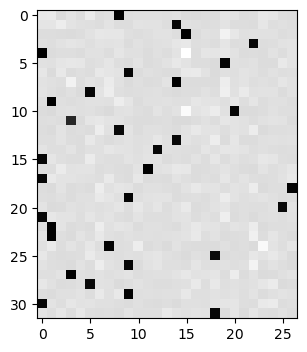

In [20]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

### Exercise 3: Deriving the Gradient of BatchNorm

In [21]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / \
    torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [22]:
dhprebn = bngain*bnvar_inv/n * \
    (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


### Exercise 4: Training with the Manual Backward Pass

In [23]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * \
    (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size  # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    
    hprebn = embcat @ W1 + b1  
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * \
        (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad  # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0:  # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7610
  10000/ 200000: 2.1740
  20000/ 200000: 2.3680
  30000/ 200000: 2.4635
  40000/ 200000: 1.9886
  50000/ 200000: 2.4168
  60000/ 200000: 2.3738
  70000/ 200000: 2.0362
  80000/ 200000: 2.4320
  90000/ 200000: 2.1038
 100000/ 200000: 2.0171
 110000/ 200000: 2.3749
 120000/ 200000: 2.0117
 130000/ 200000: 2.4325
 140000/ 200000: 2.2247
 150000/ 200000: 2.1645
 160000/ 200000: 1.9146
 170000/ 200000: 1.8998
 180000/ 200000: 2.0263
 190000/ 200000: 1.9005


In [24]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [25]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]  # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact)  # (N, n_hidden)
  logits = h @ W2 + b2  # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.0712223052978516
val 2.110548973083496


In [26]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])]  # (1,block_size,d)
      # concat into (N, block_size * n_embd)
      embcat = emb.view(emb.shape[0], -1)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact)  # (N, n_hidden)
      logits = h @ W2 + b2  # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carlah.
amelle.
khi.
mrex.
thiyah.
cassie.
mahnen.
den.
arc.
kaeli.
nellara.
chaiivon.
leigh.
ham.
join.
quinn.
shon.
marianni.
wayell.
dearyxi.
